In [48]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [49]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can i help?",name="LLM_Model")]
messages.append(HumanMessage(content=f"I Want to learn coding",name="bhupen"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLM_Model"))
messages.append(HumanMessage(content=f"I would love to learn python and ai",name="bhupen"))


for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM_Model

Please tell me how can i help?
================================ Human Message =================================
Name: bhupen

I Want to learn coding
================================== Ai Message ==================================
Name: LLM_Model

Which programming language you want to learn
================================ Human Message =================================
Name: bhupen

I would love to learn python and ai


In [51]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model='gpt-4o-mini')
result=llm.invoke(messages)

In [52]:
result.response_metadata

{'token_usage': {'completion_tokens': 603,
  'prompt_tokens': 63,
  'total_tokens': 666,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_8bda4d3a2c',
 'id': 'chatcmpl-CDWdN7zlnEqYr7ZDl3pYaRUSoS6BT',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [9]:
def add(a,b):
    """Add a and b
    
    Args:
    a (int) first int
    b (int) second int
    
    Returns:
        int
    """
    return a+b

In [10]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f03c37b10a0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f03c37b1be0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [53]:
## binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_calls=llm_with_tools.invoke([HumanMessage(content=f"What is 45 plus 55",name="bhupen")])

In [54]:
tool_calls.tool_calls

[{'name': 'add',
  'args': {'a': 45, 'b': 55},
  'id': 'call_U3GEX7wj8UQGoGIhwfIelu7z',
  'type': 'tool_call'}]

In [18]:
### using messages as set
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    name:str

In [15]:
initial_messages=[AIMessage(content=f"Please tell me how can i help?",name="LLM_Model")]
initial_messages.append(HumanMessage(content=f"I Want to learn coding",name="bhupen"))
initial_messages

[AIMessage(content='Please tell me how can i help?', additional_kwargs={}, response_metadata={}, name='LLM_Model'),
 HumanMessage(content='I Want to learn coding', additional_kwargs={}, response_metadata={}, name='bhupen')]

In [16]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLM_Model")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLM_Model')

In [17]:
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can i help?', additional_kwargs={}, response_metadata={}, name='LLM_Model', id='e7a61137-cf46-4379-b882-980fdcebb64a'),
 HumanMessage(content='I Want to learn coding', additional_kwargs={}, response_metadata={}, name='bhupen', id='4a41fe2b-4f30-4ff8-9ebb-e40bcd896b94'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLM_Model', id='de12a4ee-1f3b-473f-9f46-7a4bbc4ab8d1')]

In [36]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    name:str

# chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

def add(a,b):
    """Add a and b
    
    Args:
    a (int) first int
    b (int) second int
    
    Returns:
        int
    """
    return a+b


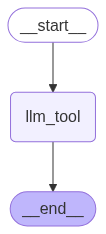

In [23]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)
builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
messages=graph.invoke({"messages":"What is 22 + 22"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 22 + 22
================================== Ai Message ==================================
Tool Calls:
  add (atqmdhnba)
 Call ID: atqmdhnba
  Args:
    a: 22
    b: 22


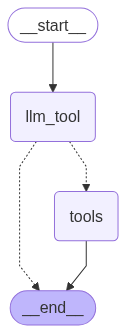

In [55]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder=StateGraph(State)
tools=[add]

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routs to END
    tools_condition,
    
    
)
builder.add_edge("tools",END)



graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
messages=graph.invoke({"messages":"What is 22 + 22"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 22 + 22
================================== Ai Message ==================================
Tool Calls:
  add (call_tqRSjdOnnWDVO4YSaSfZvOYA)
 Call ID: call_tqRSjdOnnWDVO4YSaSfZvOYA
  Args:
    a: 22
    b: 22
================================= Tool Message =================================
Name: add

44


In [57]:
messages=graph.invoke({"messages":"What is Machine Learning?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================

Machine Learning (ML) is a subset of artificial intelligence (AI) that focuses on the development of algorithms and statistical models that enable computers to perform specific tasks without explicit instructions. Instead of being programmed to perform a task, machine learning systems use patterns and inference to learn from data.

The main components of machine learning include:

1. **Data**: The foundation of machine learning. It can be structured (like tables) or unstructured (like text or images). The quality and quantity of data can significantly impact the performance of ML models.

2. **Algorithms**: These are mathematical models that process data to learn patterns and make predictions. Common algorithms include decision trees, support vector machines, neural networks, and clustering algorith